# Project 3 - Sentiment Analysis for E-Commerce Store
### by Azubuogu Peace Udoka

### Table of Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Understanding the Dataset</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#ques">Calculating Metrics</a></li>
<li><a href="#conc">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Background
As a data analyst at an e-commerce store, I have access to a dataset containing product reviews and associated ratings. The task is to build a model that can classify each review as positive, negative, or neutral based on the text content.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize 
from wordcloud import WordCloud #ensure wordcloud is installed

%matplotlib inline
#set general style of plots
sns.set(rc = {'figure.figsize':(20,8)}, style="white", font_scale=1.5)


import warnings
warnings.simplefilter("ignore")

### Exploring the Dataset

In [4]:
data = pd.read_csv('Amazon Product Review.txt')
# view 5 random rows of data
data.sample(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
18414,US,14767528,R3SCVLAUWP1OTK,B00LCHRQL6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Great Kindle,My kids love these! We bought the kid friendl...,2015-01-20,1
10633,US,12349073,R1G7ISRKCUDB5X,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,1,2,3,N,Y,Buyers Beware!,My review is more for the support of Amazon th...,2015-04-26,0
17110,US,48518157,RRYPV2P7KBLVL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Goes with me everywhere,2015-01-31,1
18120,US,1590252,R2GFJHCBNQI078,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,Y,Nice product. However,"Delivered on time.Nice product. However,we did...",2015-01-22,1
15274,US,2854574,R41566D5I1IZL,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great quality for the money.,2015-02-18,1


In [5]:
# size of dataset
data.shape

(30846, 16)

There are 30846 rows of data and 16 columns

In [6]:
# checking for missing values
data.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64

There are no missing values.

In [7]:
# checking for duplicates
data.duplicated().sum()

0

There are no dupicates.

In [8]:
data.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
sentiment             int64
dtype: object

In [9]:
# converting customer_id and product_parent column to string and review_date column to date
data['customer_id'] = data['customer_id'].astype('str')
data['product_parent'] = data['product_parent'].astype('str')
data['review_date'] = pd.to_datetime(data['review_date'])

In [10]:
# fraction of positive and negative reviews
data.sentiment.value_counts()/len(data)

1    0.835343
0    0.164657
Name: sentiment, dtype: float64

The sentiment column contains two values.

0 - negative sentiment

1 - positive sentiment

This means, majority of the reviews are positive (83.5343%) and 16.4657% of the reviews are negative.

### VIsualisation
To get a general idea of the type of reviews gotten, we will visualise the words using a wordcloud.

In [18]:
# create a variable for the words in the review body
word_body = " ".join(review for review in data.review_body)
# create a variable for the words in the review headline
word_head = " ".join(review for review in data.review_headline)

In [19]:
# create word cloud for the review body
word_cloud_1 = WordCloud(collocations = False, background_color = 'white').generate(word_body)
# create word cloud for the review headline
word_cloud_2 = WordCloud(collocations = False, background_color = 'white').generate(word_head)

### Plotting Review Body WordCloud

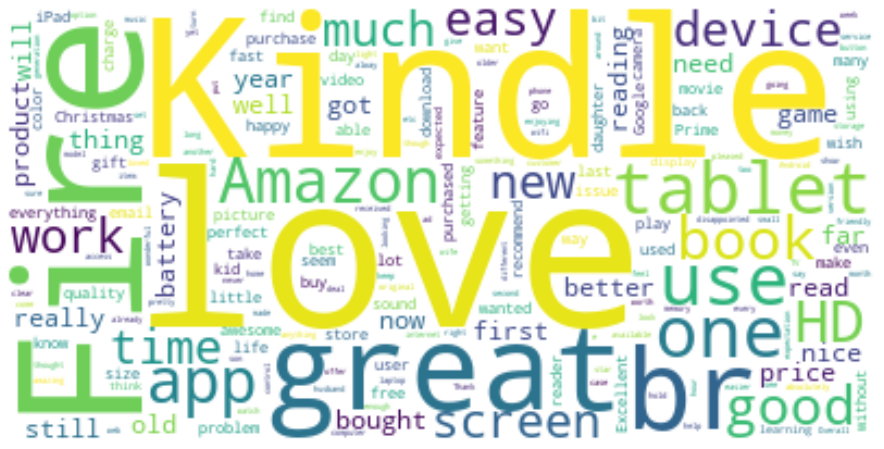

In [20]:
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Plotting Review Body WordCloud

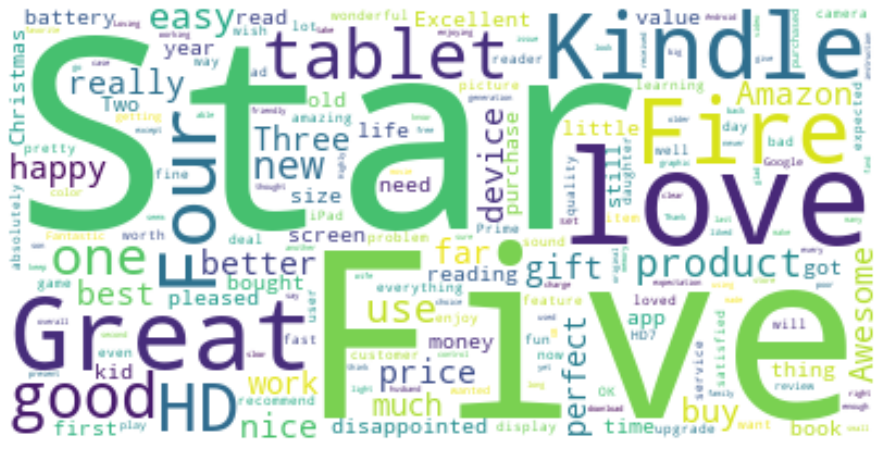

In [21]:
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud, we can agree to the percentages earlier found that most of the reviews are positive.

In [11]:
# create new column containing number of words from each review_body
word_tokens = [word_tokenize(review) for review in data.review_body]
length = []
 
for i in range(len(word_tokens)):
    length.append(len(word_tokens[i]))
data['no_of_words'] = length  